In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
npileup = 200

## Let's load the data files

In [3]:
data_dir = os.path.join('..', '..', '..', 'data')
root_dir = os.path.join(data_dir, 'Pythia8', 'pileup-{}'.format(npileup))

hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith('-hits.csv')])
hit_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
           for file in hit_files]

initial_files = sorted([file for file in os.listdir(root_dir) if file.endswith('-particles_initial.csv')])
initial_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
               for file in initial_files]

final_files = sorted([file for file in os.listdir(root_dir) if file.endswith('-particles_final.csv')])
final_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
             for file in final_files]

Let's load an event and check the performance of the Purified Hough Transform.

In [4]:
from src.utils.preprocessing import preprocess_hit_df, remove_low_pt_tracks, \
    preprocess_initial_final_df, get_list_based_data

# choose an event randomly
num_events = 100
random.seed(3082021)
random_event = random.choice(range(0, num_events))
df = hit_dfs[random_event]
initial_df = initial_dfs[random_event]

# preprocess the dataframes
preprocess_hit_df(df)
preprocess_initial_final_df(initial_df)

# remove low p_T tracks
df, initial_df = remove_low_pt_tracks(df, initial_df)

# get all the important data in lists so we can query them in (actual) O(1) time
list_based_data = get_list_based_data(df)
xy_tracks, rz_tracks, particles, pids, weights, pid_to_total_weight = list_based_data

print(f'Event chosen: {hit_files[random_event]}')
print(f'df shape: {df.shape}')
initial_df.head()

Event chosen: event000000085-hits.csv
df shape: (42168, 21)


,index,particle_id,particle_type,process,vx,vy,vz,vt,px,py,pz,m,q,pt,|p|,theta,eta
0,2,4503599677702144,-321,0,0.021071,0.013023,-128.09848,-4.308757,-0.753295,0.684963,-219.511871,0.49368,-1,1.018149,219.514232,3.136954,-6.066572
1,6,4503599778365440,-211,0,0.021071,0.013023,-128.09848,-4.308757,-0.634171,-0.331501,-4.461843,0.13957,-1,0.715588,4.518861,2.982567,-2.529729
2,7,4503599795142656,-211,0,0.021071,0.013023,-128.09848,-4.308757,-0.062144,-0.500610,-37.906170,0.13957,-1,0.504453,37.909526,3.128286,-5.012586
3,9,4503599828697088,2212,0,0.021071,0.013023,-128.09848,-4.308757,0.759758,1.419072,-4937.240230,0.93827,1,1.609657,4937.240492,3.141267,-8.721688
4,13,4503599895805952,211,0,0.021071,0.013023,-128.09848,-4.308757,-0.471593,-0.788552,-119.688988,0.13957,1,0.918811,119.692515,3.133916,-5.562733


Text(0.5, 1.0, 'xy view')

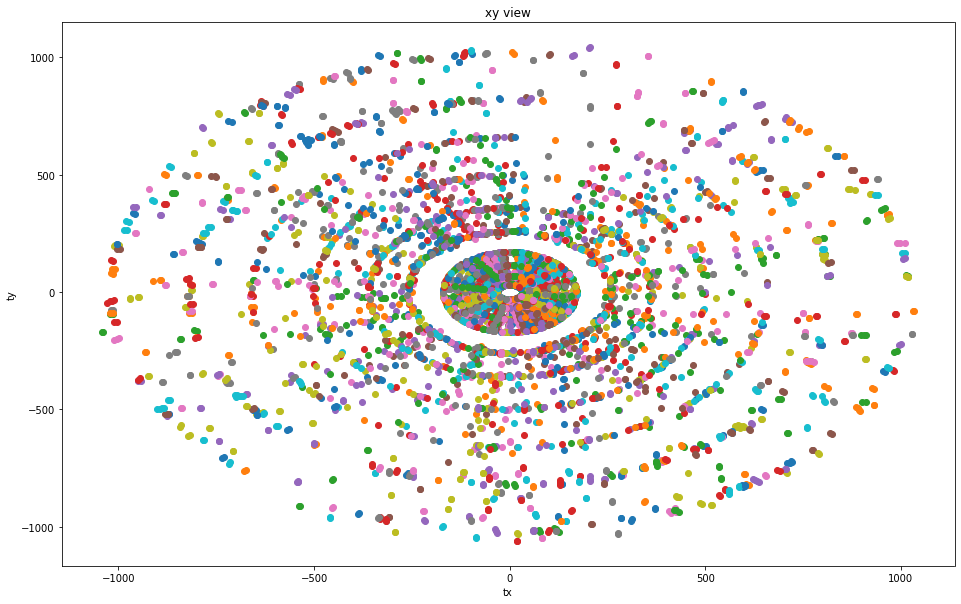

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
for pid in particles:
    particle_df = df[df['particle_id'] == pid]
    ax.scatter(particle_df['tx'], particle_df['ty'])

ax.set_xlabel('tx')
ax.set_ylabel('ty')
ax.set_title('xy view')

Hyperparameters

In [5]:
xy_hyperparams = {
    'bin-size': (0.001, 0.2),
    'xrange': (-np.pi, np.pi),
    'yrange': (-1000, 1000),
    'minimum-hits-per-bin': 10
}

rz_hyperparams = {
    'bin-size': (0.04, 20),
    'xrange': (-15, 15),
    'yrange': (-50000, 50000),
    'minimum-hits-per-bin': 6
}

threshold_x = 3500 * xy_hyperparams['bin-size'][0]
threshold_y = 1000 * xy_hyperparams['bin-size'][1]
closeness_thresholds = (threshold_x, threshold_y)
similarity_threshold = 0.5


Import algorithms

In [6]:
from src.utils.hough_transform import compute_approximate_qpt, hough2d_pipeline
from src.utils.purification import purify_xy_estimations
from src.utils.preprocessing import get_track_to_geometry_mapping
from src.utils.duplicate_removal import duplicate_removal_1
from src.utils.list_based_metrics import efficiency_rate, fake_rate, duplicate_rate

In [7]:
def compute_and_print_results(est, _pids, _weights, _pid_to_total_weight,
                              transform_type):
    """ Computes metrics and prints them. """
    eff = efficiency_rate(est.values(), _pids, _weights, _pid_to_total_weight)
    fake = fake_rate(est.values(), _pids, _weights, _pid_to_total_weight)
    dup = duplicate_rate(est.values(), _pids, _weights, _pid_to_total_weight)
    print(f'{transform_type} statistics:')
    print(f'\tEfficiency Rate: {eff:.2f}')
    print(f'\tFake Rate: {fake:.2f}')
    print(f'\tDuplicate Rate: {dup:.2f}')
    print(f'\tNumber of tracks estimated: {len(est)}')
    print()

In [8]:
# run the Hough Transform
_, xy_est = hough2d_pipeline(xy_tracks, xy_hyperparams,
                             compute_approximate_qpt, use_tqdm=True)
compute_and_print_results(xy_est, pids, weights, pid_to_total_weight,
                          'xy Transform')

# purify the results
pur_xy_est = purify_xy_estimations(xy_est, rz_hyperparams, df)
compute_and_print_results(pur_xy_est, pids, weights, pid_to_total_weight,
                          'Purified xy Transform')

# remove duplicates
hit_to_geom = get_track_to_geometry_mapping(df)
pur_new_est = duplicate_removal_1(pur_xy_est,
                                  closeness_thresholds,
                                  similarity_threshold,
                                  remove_same_geometries=False,
                                  hit_to_geom=hit_to_geom)
compute_and_print_results(pur_new_est, pids, weights, pid_to_total_weight,
                          'Purified xy Transform (Duplicate Removal 1)')

# remove reconstructed tracks with P_T bigger than 0.6 GeV
final_est = {track: hits for track, hits in pur_new_est.items()
             if abs(track[1]) < (1 / 0.6)}
compute_and_print_results(final_est, pids, weights, pid_to_total_weight,
                          'Purified xy Transform (Duplicate Removal 1) '
                          'Filtered Reco tracks with pt > 0.6 GeV')

Hough Transform:   0%|          | 0/42168 [00:00<?, ?it/s]

Efficiency Rate:   0%|          | 0/5639215 [00:00<?, ?it/s]

Fake Rate:   0%|          | 0/5639215 [00:00<?, ?it/s]

Duplicate Rate:   0%|          | 0/5639215 [00:00<?, ?it/s]

xy Transform statistics:
	Efficiency Rate: 0.93
	Fake Rate: 0.79
	Duplicate Rate: 1.00
	Number of tracks estimated: 5639215



Purification of xy estimated tracks:   0%|          | 0/5639215 [00:00<?, ?it/s]

KeyboardInterrupt: 

Let's define a custom efficiency rate function that will also return the particles found.

In [ ]:
from src.utils.metrics import get_track_to_truth_row_mapping, matching_probability

def custom_efficiency_rate(est, truth_df, threshold=0.5):
    """ Custom efficiency rate function. The difference is that it also returns the reconstructed particles. """
    num_true_particles = len(set(truth_df['particle_id']))
    track_to_truth_df_row = get_track_to_truth_row_mapping(truth_df)
    found_particles = set()
    pid_to_est_track = {}

    for _track, hits in est.items():
        _pid, prob = matching_probability(hits, track_to_truth_df_row, truth_df)
        if prob >= threshold and _pid not in found_particles:
            found_particles.add(_pid)
            pid_to_est_track[_pid] = _track
        if len(found_particles) == num_true_particles:
            break

    return pid_to_est_track, len(found_particles) / len(set(truth_df['particle_id']))

Now let's take a look at which particles were found, in order to see the frequency for every pdg.

In [ ]:
particle_to_track, efficiency = custom_efficiency_rate(pur_new_est, df)
real_counts_per_pdg = dict(initial_df['particle_type'].value_counts())
reco_counts_per_pdg = {pdg: 0 for pdg in real_counts_per_pdg}

for reco_particle in particle_to_track:
    pdg = initial_df[initial_df['particle_id'] == reco_particle]['particle_type'].iloc[0]
    reco_counts_per_pdg[pdg] += 1

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(17, 11))

# first plot: residual per phi
n_pdgs = len(real_counts_per_pdg)
xticks_r = np.arange(0, n_pdgs)
count_max = max(real_counts_per_pdg.values())
bar_width = 0.2

ax.bar(xticks_r - (bar_width / 2), list(reco_counts_per_pdg.values()), color='crimson',
       label='Reco Counts', width=bar_width)
ax.bar(xticks_r + (bar_width / 2), list(real_counts_per_pdg.values()), color='forestgreen',
       label='Real Counts', width=bar_width)

ax.set_xlabel('pdg')
ax.set_xticks(xticks_r)
ax.set_xticklabels(list(real_counts_per_pdg), fontsize=9)
ax.set_ylabel('Count').set_rotation(0)
ax.yaxis.set_label_coords(-0.05, 0.50)
ax.set_yticks(np.arange(0, count_max + 1))
ax.set_title('Counts vs pdg')
ax.legend()

plt.show()